In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
import matplotlib.pyplot as plt
import time

In [43]:
# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Keras Tuner
import keras_tuner as kt
from kerastuner.tuners import RandomSearch

In [44]:
# Load Dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test= x_train / 255.0, x_test / 255.0
print(x_train.shape, x_test.shape)
## Define Early Stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

(60000, 28, 28) (10000, 28, 28)


In [61]:
# Build Model
def build_model4(hp):
    model4 = tf.keras.Sequential([
        keras.layers.Conv2D(
            filters = hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
            kernel_size = hp.Choice('conv_1_kernel', values = [3,5]),
            activation = 'relu',
            input_shape = (28,28,1)
        ),
        keras.layers.Conv2D(
            filters = hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
            kernel_size = hp.Choice('conv_2_kernel', values = [3,5]),
            activation = 'relu'
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units = hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
            activation = 'relu'
        ),
        keras.layers.Dense(10, activation='softmax')
    ])

    model4.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    return model4

In [62]:
tuner4 = kt.Hyperband(
    build_model4,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='KerasTuner/output',
    project_name='MNIST_KerasTuner4'
)

INFO:tensorflow:Reloading Tuner from KerasTuner/output/MNIST_KerasTuner4/tuner0.json


In [63]:
tuner4.search_space_summary()

Search space summary
Default search space size: 6
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001], 'ordered': True}
filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': 'linear'}


In [65]:
# Measure the execution time for hyperparameter tuning
start_time = time.time()
tuner4.search(x_train, y_train,
             epochs=5,
             validation_data=(x_test, y_test),
             callbacks=[stop_early])

end_time = time.time()

exec_time4= end_time - start_time
print("Execution Time (Hyperband): ", exec_time4, " seconds")

INFO:tensorflow:Oracle triggered exit
Execution Time (Hyperband):  0.001871347427368164  seconds


In [66]:
tuner4.results_summary()

Results summary
Results in KerasTuner/output/MNIST_KerasTuner4
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0006 summary
Hyperparameters:
activation: tanh
learning_rate: 0.001
filters: 64
kernel_size: 3
dense_units: 128
layers: 3
conv_1_filter: 128
conv_1_kernel: 3
conv_2_filter: 64
conv_2_kernel: 5
dense_1_units: 64
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9896000027656555

Trial 0005 summary
Hyperparameters:
activation: relu
learning_rate: 0.0001
filters: 64
kernel_size: 3
dense_units: 128
layers: 4
conv_1_filter: 48
conv_1_kernel: 3
conv_2_filter: 48
conv_2_kernel: 3
dense_1_units: 128
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9886000156402588

Trial 0007 summary
Hyperparameters:
activation: tanh
learning_rate: 0.0001
filters: 32
kernel_size: 5
dense_units: 64
layers: 2
conv_1_filter: 32
conv_1_kernel: 5
conv_2_filter: 48
conv_2_kernel: 3
dense_1_units: 112
tuner/epochs: 5
t

In [67]:
best_hps4 = tuner4.get_best_hyperparameters(num_trials=1)[0]
## Build the model with the best hyperparameters

model4 = tuner4.hypermodel.build(best_hps4)
history4 = model4.fit(x_train, y_train,epochs=5, validation_split=0.2, callbacks=[stop_early])

Epoch 1/5
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1124 - accuracy: 0.9656 - val_loss: 0.0560 - val_accuracy: 0.9837
Epoch 2/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0385 - accuracy: 0.9879 - val_loss: 0.0428 - val_accuracy: 0.9863
Epoch 3/5
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0240 - accuracy: 0.9924 - val_loss: 0.0463 - val_accuracy: 0.9874
Epoch 4/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.0667 - val_accuracy: 0.9847
Epoch 5/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.0585 - val_accuracy: 0.9871


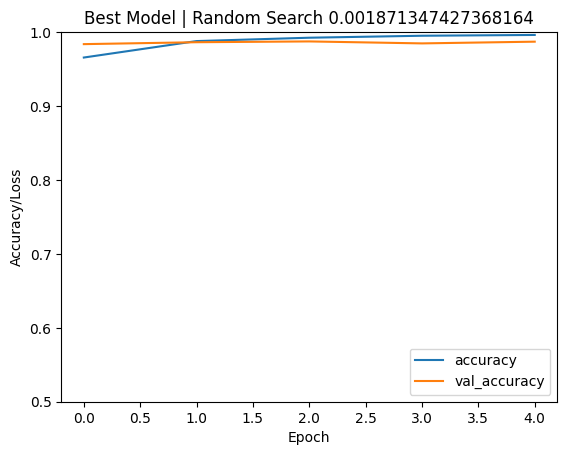

In [68]:
# Plot the learning curves for training and validation accuracy/loss for the best model
plt.plot(history4.history['accuracy'], label='accuracy')
plt.plot(history4.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model | Random Search {}'.format(exec_time4))
plt.show()

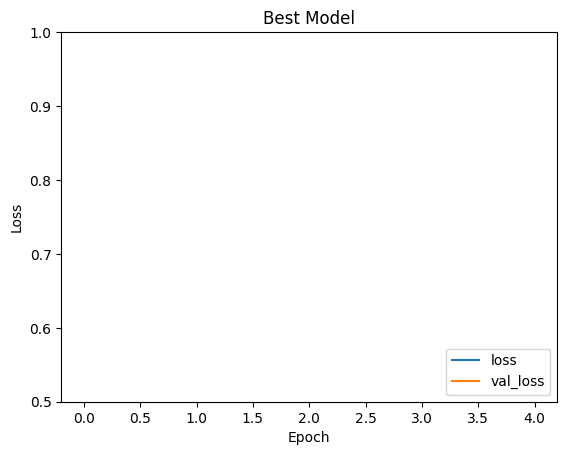

In [69]:
# Plot the loss for the best model
plt.plot(history4.history['loss'], label='loss')
plt.plot(history4.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Best Model')
plt.show()

----

In [70]:
# Build Model
def build_model5(hp):
    model5 = tf.keras.Sequential()
    
    # Input layer
    model5.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
    
    # Add Conv2D layers iteratively
    for i in range(hp.Int('num_layers', 2, 10, step=2)):
        model5.add(keras.layers.Conv2D(
            filters = hp.Int(f'conv_{i+1}_filter', min_value=32, max_value=128, step=16),
            kernel_size = hp.Choice(f'conv_{i+1}_kernel', values = [3,5]),
            activation = 'relu'
        ))
    
    model5.add(keras.layers.Flatten())
    model5.add(keras.layers.Dense(
        units = hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation = 'relu'
    ))
    model5.add(keras.layers.Dense(10, activation='softmax'))

    model5.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    return model5

tuner5 = kt.Hyperband(
    build_model5,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='KerasTuner/output',
    project_name='MNIST_KerasTuner5'
)

tuner5.search_space_summary()
tuner5.search(x_train, y_train,
             epochs=5,
             validation_data=(x_test, y_test),
             callbacks=[stop_early])


Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.9905999898910522

Best val_accuracy So Far: 0.9918000102043152
Total elapsed time: 00h 08m 50s
INFO:tensorflow:Oracle triggered exit


In [71]:
import os
import visualkeras
from PIL import ImageFont

In [72]:
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf" # change this to the path of the font file in your system
font = ImageFont.truetype(font_path, 12)

In [79]:
file_path = "/home/roderickperez/DS_projects/autoencoders/images/MNIST/KerasTuner/"

In [75]:
best_hps5 = tuner5.get_best_hyperparameters(num_trials=1)[0]
## Build the model with the best hyperparameters

model5 = tuner5.hypermodel.build(best_hps5)
history5 = model5.fit(x_train, y_train,epochs=5, validation_split=0.2, callbacks=[stop_early])

Epoch 1/5
1500/1500 [==============================] - 12s 7ms/step - loss: 0.1343 - accuracy: 0.9597 - val_loss: 0.0514 - val_accuracy: 0.9852
Epoch 2/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0502 - accuracy: 0.9848 - val_loss: 0.0544 - val_accuracy: 0.9843
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0360 - accuracy: 0.9886 - val_loss: 0.0567 - val_accuracy: 0.9846
Epoch 4/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0250 - accuracy: 0.9921 - val_loss: 0.0462 - val_accuracy: 0.9881
Epoch 5/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.0492 - val_accuracy: 0.9873


In [80]:
visualkeras.layered_view(model5, legend=True, font=font).save(file_path + "kerasTuner_Model5.png")